# A Machine Learning Exploration of Financial Literacy Determinants in Italy

- Enrico Mannarino (850859)

- Thomas Passera (901685)

- Christian Persico (829558)

- Giorgia Prina (858740)

### Abstract

Financial literacy is remarkably important in today's complex world. Italy is at a disadvantage because its citizens are not as financially literate as those of other major economies. This puts both individuals and the whole country at risk when it comes to financial matters.
Using data provided by the answers to a questionnaire administered by the Bank of Italy in 2017, our aim was, in addition to a detailed analysis, the use of machine learning models that allow, by classifying individuals to identify the main factors influencing the level of financial knowledge of Italian adults.
This work is intended as a tool to support national and international institutions, as well as policy makers and financial analysts who, on the basis of the results obtained, have the possibility to intervene in a targeted manner to contribute to the development of financial education in the country.

## Data exploration

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
import statsmodels.api as sm

KernelInterrupted: Execution interrupted by the Jupyter kernel.

The documentation from the Bank of Italy provides us with the following information:  

1) the Italian sample comprises approximately 2,500 individuals who were interviewed using two distinct methods: 40% of them underwent face-to-face interviews, while the rest utilized tablets to record their responses.

2) the study reveal a significant disparity in financial literacy between Italy and other G20 countries, with this disparity being particularly pronounced among less educated respondents, the elderly, and women. Compared to other nations, Italians exhibit a greater awareness of their limitations or, in any case, are more cautious in assessing their level of financial knowledge.

The existing body of scientific literature has predominantly investigated this form of inequality through the utilization of traditional methods and regression models. Our current objective is to employ machine learning methodologies in an attempt to mitigate specific forms of bias. Given that our analysis encompasses the examination of outcomes derived from the BoI and OECD, our preference lies in enabling the model to autonomously assimilate the provided data, thereby mitigating the potential for external influence. Additionally, these models will afford us the capability to discern the primary components within the analysis. A more intricate elaboration on this aspect will be provided in the subsequent section dedicated to modeling.

In [ ]:
data = "Indagine 2017.csv"
df = pd.read_csv(data, usecols=lambda col: col != 'id')
df

,pesofitc,qf1,qf2,qf3_1,qf3_3,qf3_4,qf3_6,qf3_7,qf3_8,qf3_99,...,qk7_2,qk7_3,qd1,qd5b,qd7,qd9,qd10,qd12,SM,AREA5
0,0.706596,2,0,0,0,0,0,0,1,0,...,1,0,0,3,31,3,5,1,0,1
1,1.220904,2,1,0,0,0,1,0,0,0,...,1,1,0,3,53,4,1,1,0,1
2,1.797774,1,0,0,0,0,0,0,1,0,...,1,1,0,1,70,4,6,1,0,4
3,1.515358,2,0,0,0,0,0,0,1,0,...,1,-97,0,2,64,4,4,1,0,4
4,0.244932,2,0,0,0,0,0,0,1,0,...,0,0,1,2,50,3,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,3.113144,3,1,1,0,0,0,0,0,0,...,-97,-97,1,4,18,4,9,1,1,3
2372,2.112678,1,0,1,0,0,0,0,0,0,...,1,-97,0,1,68,4,6,1,1,3
2373,2.090212,3,1,1,0,0,0,0,0,0,...,-97,0,0,2,31,1,2,1,1,3
2374,2.040491,3,0,0,0,0,0,0,1,0,...,-97,-97,1,4,18,3,9,1,1,3


We decided to rename some variables to make them more understandable during analysis.

In [ ]:
df.rename(columns={"AREA5": "geography", "SM":"type_interview", "qd1":"gender",
                    "qd9":"education", "qd7":"age", "qd10":"employment_status",
                    "qd12":"country_of_birth", "qd5b":"family_members"}, 
            inplace=True)

### Null values

There are no instances of missing values necessitating correction. Instead, the questionnaire's design entails the exclusion of certain questions contingent upon preceding responses. In essence, specific questions elicit binary responses of "yes" or "no," and based on these answers, a subsequent series of questions is either presented or bypassed.

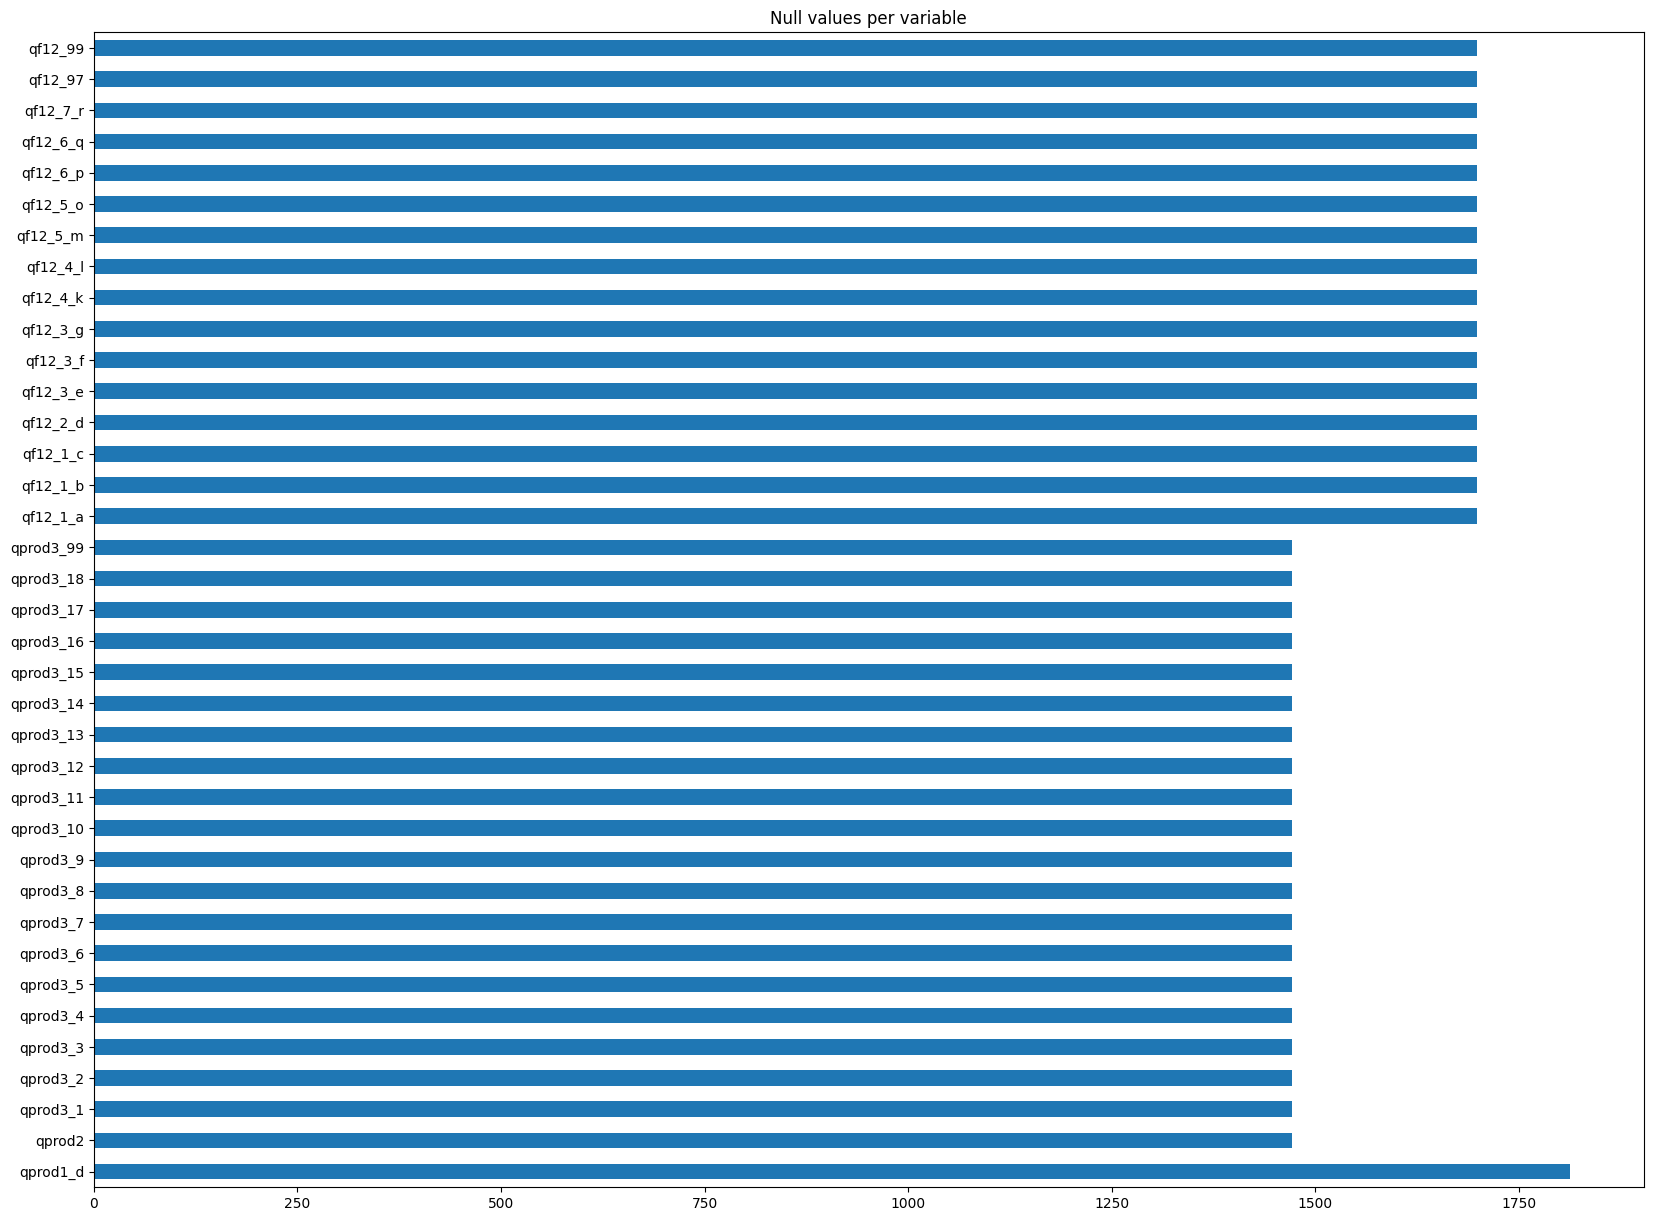

In [ ]:
missing_values = df.isnull().sum()

missing_values_filtered = missing_values[missing_values > 0]

plt.figure(figsize=(20, 15))
missing_values_filtered.plot(kind='barh')
plt.title('Null values per variable')
plt.show()

### Categorisation

In [ ]:
list_of_name = ['qf3', 'qf9', 'qprod1c', 'qprod3', 'qf10', 'qprod4', 'qf12', 'qk7']

list_of_partials = [df[['qf3_1', 'qf3_3', 'qf3_4', 'qf3_6', 'qf3_7', 'qf3_8', 'qf3_99']],
                    df[['qf9_1', 'qf9_2', 'qf9_3', 'qf9_4', 'qf9_5', 'qf9_6', 'qf9_7',
                        'qf9_8', 'qf9_9', 'qf9_10', 'qf9_99']],
                    df[['qprod1c_1', 'qprod1c_2', 'qprod1c_10', 'qprod1c_11', 'qprod1c_12',
                        'qprod1c_3', 'qprod1c_5', 'qprod1c_6', 'qprod1c_14', 'qprod1c_7',
                        'qprod1c_8', 'qprod1c_99']],
                    df[['qprod3_1', 'qprod3_2', 'qprod3_3', 'qprod3_4', 'qprod3_5', 'qprod3_6',
                        'qprod3_7', 'qprod3_8', 'qprod3_9', 'qprod3_10', 'qprod3_11', 'qprod3_12',
                        'qprod3_13', 'qprod3_14', 'qprod3_15', 'qprod3_16', 'qprod3_17', 'qprod3_18',
                        'qprod3_99']],
                    df[['qf10_1', 'qf10_2', 'qf10_3', 'qf10_4', 'qf10_5', 'qf10_6', 'qf10_7',
                        'qf10_8', 'qf10_9', 'qf10_10', 'qf10_11', 'qf10_12']],
                    df[['qprod4_1', 'qprod4_2', 'qprod4_3']],
                    df[['qf12_1_a', 'qf12_1_b', 'qf12_1_c', 'qf12_2_d', 'qf12_3_e', 'qf12_3_f',
                        'qf12_3_g', 'qf12_4_k', 'qf12_4_l', 'qf12_5_m', 'qf12_5_o', 'qf12_6_p',
                        'qf12_6_q', 'qf12_7_r', 'qf12_97', 'qf12_99']],
                    df[['qk7_1', 'qk7_2', 'qk7_3']]]

Categorization of the first multiple questions:

The function accepts as arguments: the dataframe consisting of the binary columns, the pre-treated name of the columns as a string, and the list of possible responses given by the questionnaire. It adds the corresponding categorical column at the tail of the initial partial dataframe.

In [ ]:
def Categorize_binary_class(df, elenco_df_parziali, nuove_colonne):

    for nome_nuova_colonna, df_parziale in zip(nuove_colonne, elenco_df_parziali):

        lista_possibili_risposte = []
        for string in df_parziale.columns.tolist():
            match = re.search(r'_(\d+_\w+|\d+)', string)
            if match:
                lista_possibili_risposte.append(match.group(1))

        df_temp = df_parziale.loc[:, df_parziale.isin([0,1,'0','1']).all()].astype(int)

        df[nome_nuova_colonna] = df_temp.dot(df_temp.columns + ',').str.rstrip(',')

        df[nome_nuova_colonna] = df.apply(lambda row: ', '.join([str(number) for number in lista_possibili_risposte if any(row[column] == 1 for column in df_parziale.columns.tolist() if f'{nome_nuova_colonna}_{number}' in column)]), axis=1)

In [ ]:
Categorize_binary_class(df, list_of_partials, list_of_name)

In [ ]:
df = df.replace('', np.nan)
df

,pesofitc,qf1,qf2,qf3_1,qf3_3,qf3_4,qf3_6,qf3_7,qf3_8,qf3_99,...,type_interview,geography,qf3,qf9,qprod1c,qprod3,qf10,qprod4,qf12,qk7
0,0.706596,2,0,0,0,0,0,0,1,0,...,0,1,8,5,NaN,NaN,"1, 4, 9",NaN,NaN,"1, 2"
1,1.220904,2,1,0,0,0,1,0,0,0,...,0,1,6,"4, 7, 9","1, 10, 6, 7","1, 4, 11, 17","1, 4, 6",1,NaN,"1, 2, 3"
2,1.797774,1,0,0,0,0,0,0,1,0,...,0,4,8,"1, 10",NaN,NaN,"1, 4, 6, 9, 10",NaN,NaN,"1, 2, 3"
3,1.515358,2,0,0,0,0,0,0,1,0,...,0,4,8,7,NaN,NaN,"1, 4, 6, 10",NaN,NaN,"1, 2"
4,0.244932,2,0,0,0,0,0,0,1,0,...,0,4,8,1,NaN,NaN,"1, 4, 6",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,3.113144,3,1,1,0,0,0,0,0,0,...,1,3,1,"9, 99",NaN,NaN,NaN,NaN,NaN,NaN
2372,2.112678,1,0,1,0,0,0,0,0,0,...,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,2
2373,2.090212,3,1,1,0,0,0,0,0,0,...,1,3,1,1,99,"9, 99",NaN,NaN,NaN,1
2374,2.040491,3,0,0,0,0,0,0,1,0,...,1,3,8,1,NaN,NaN,NaN,NaN,NaN,1


Transforms the newly created variables into category format

In [ ]:
for name in list_of_name:
    df[name] = df[name].astype('category')

## Composition of scorings and their computation

The questionnaire comprises a total of 21 questions (both single and multiple choice). Analogous to the approach adopted by the OECD, we have chosen to categorize these questions into four distinct indices. Specifically, we have opted to leverage the insights presented in Annex 2 of the document titled "G20-OECD-INFE-report-adult-financial-literacy-in-G20-countries.pdf" to formulate these indices exclusively for the Italian context:

1) Financial Knowledge Score
2) Financial Behavior Score
3) Financial Attitudes Score
4) Overall Financial Literacy Score.

Using this source to create the scores allows us to obtain ratings that are comparable with those of the studies done by the OECD.

### Financial knowledge score

- QK3 (1 point for C or D; 0 others); QK4 (1 point for response 0); QK5 (1 point for 102); QK6 (1 for a correct response to QK6 [1] if and only if the response to “Calculation of interest plus principal” (QK5) was also correct. 0 in all other cases.); QK7_1 (1 for a correct response [1/True]. 0 in all other cases.); QK7_2 (1 for a correct response [1/True]. 0 in all other cases.); QK7_3 (1 for a correct response [1/True]. 0 in all other cases.).

### Financial behaviour score

- QF1, QF2 (1 point if personally or jointly responsible for money management [QF1=1 or 2] AND household has a budget [QF2=1]. 0 in all other cases.); QF3 (1 point for any type of active saving (answers a, c, d, e, f, g), and relevant options added at the national level. 0 in all other cases. Letting money build up in a bank account is not considered to be active saving (answer b) and gives 0 points towards the score. ); QF10_1 (1 point for respondents who put themselves at 1 or 2 on the 
scale [agree]. 0 in all other cases.); QF10_4 (1 point for respondents who put themselves at 1 or 2 on the scale [agree]. 0 in all other cases.); QF10_6 (1 point for respondents who put themselves at 1 or 2 on the scale [agree]. 0 in all other cases.); QF10_7 (1 point for respondents who put themselves at 1 or 2 on the scale [agree]. 0 in all other cases.); Qprod2 AND Qprod3 (Two intermediate --> Qprod_D1: 1 if variable Qprod2 is equal to 1 or 4 and  0 otherwise)(Qprod_D2: 1 if yes at Qprod3 b, c, d, i, j, k, l, m or r; 2 if yes at Qprod3 e, f, g or h; 0 otherwise.) The final variable – Qb7_new (2 if CProd_D2 =2; 1 if CProd_D1 =1 or CProd_D2 =1; 0 Otherwise); QF12 (0 if the respondent used credit to make ends meets; 1 all other).

### Financial attitudes score 

- (QF10_2 + QF10_3 + QF10_8) / 3

### Overall financial literacy score

- Knowledge + Behaviour + Attitudes = Overall

In [ ]:
# FINANCIAL KNOWLEDGE SCORE -> ranges from 0 to 7
# FINANCIAL BEHAVIOUR SCORE -> ranges from 0 to 9
# FINANCIAL ATTITUDES SCORE -> ranges from 1 to 5
# OVERALL FINANCIAL LITERACY SCORE -> ranges from 1 to 21 and can be normalised 
#                                     to 100 for reporting by multiplying by 100/21

def calculate_fin_knowledge_score(df):
    fin_knowledge_score = 0 

    if df["qk3"] in [3, -97]:
        fin_knowledge_score += 1

    if df["qk4"] == 0:
        fin_knowledge_score += 1

    if df["qk5"] == 102:
        fin_knowledge_score += 1    

    if df["qk6"] == 1 and df["qk5"] == 102:
        fin_knowledge_score += 1

    qk7_columns = ['qk7_1', 'qk7_2', 'qk7_3']
    fin_knowledge_score += sum(df[col] == 1 for col in qk7_columns)
    
    return fin_knowledge_score


def calculate_fin_behaviour_score(df):
    fin_behaviour_score = 0

    if (df["qf1"] == 1 or df["qf1"] == 2) and df["qf2"] == 1:
        fin_behaviour_score += 1

    qf3_columns = ["qf3_1", "qf3_4", "qf3_6", "qf3_7", "qf3_8", "qf3_99"]
    if any(df[col] == 1 for col in qf3_columns):
        fin_behaviour_score += 1
        
    for col in ["qf10_1", "qf10_4", "qf10_6", "qf10_7"]:
        if df[col] in [1,2]:
            fin_behaviour_score += 1

    Qprod_D1 = 0
    Qprod_D2 = 0
    Qb7_new = 0

    if df["qprod2"] in [1,4]:
        Qprod_D1 = 1

    qprod3_1_columns = ["qprod3_2", "qprod3_3", "qprod3_4",
                        "qprod3_9", "qprod3_10", "qprod3_11",
                        "qprod3_12", "qprod3_13", "qprod3_18"]

    if any(df[col] == 1 for col in qprod3_1_columns):
        Qprod_D2 = 1

    qprod3_2_columns = ["qprod3_5", "qprod3_6", "qprod3_7", "qprod3_8"]
    if any(df[col] == 1 for col in qprod3_2_columns):
        Qprod_D2 = 2

    if Qprod_D2 == 2:
        fin_behaviour_score += 2
    elif Qprod_D1 == 1 or Qprod_D2 == 1:
        fin_behaviour_score += 1

    qf12_columns = ["qf12_1_a", "qf12_1_b", "qf12_1_c", "qf12_2_d"]
    if any(df[col] == 1 for col in qf12_columns):
        fin_behaviour_score += 1

    return fin_behaviour_score

The following chunk of code creates new columns in the dataframe to add the calculated score results.

In [ ]:
df["fin_knowledge_score"] = df.apply(calculate_fin_knowledge_score, axis=1)
df["fin_behaviour_score"] = df.apply(calculate_fin_behaviour_score, axis=1)
df["fin_attitudes_score"] = round(df[["qf10_2", "qf10_3", "qf10_8"]].apply(lambda row: row[row >= 0].mean(), axis=1), 3)

df = df.dropna(subset=['fin_attitudes_score'])

df["overall_fl_score"] = (df["fin_knowledge_score"] + df["fin_behaviour_score"] + df["fin_attitudes_score"])* 100 / 21

df[["fin_knowledge_score", "fin_behaviour_score", "fin_attitudes_score", "overall_fl_score"]]

/tmp/ipykernel_203/2173207315.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["overall_fl_score"] = (df["fin_knowledge_score"] + df["fin_behaviour_score"] + df["fin_attitudes_score"])* 100 / 21


,fin_knowledge_score,fin_behaviour_score,fin_attitudes_score,overall_fl_score
0,6,3,2.333,53.966667
1,7,7,4.000,85.714286
2,6,4,5.000,71.428571
3,3,5,5.000,61.904762
4,0,4,4.333,39.680952
...,...,...,...,...
2371,2,1,3.333,30.157143
2372,3,2,3.667,41.271429
2373,1,1,3.333,25.395238
2374,2,1,3.667,31.747619


Stats of the new variables:

- fin_knowledge_score

In [ ]:
df['fin_knowledge_score'].describe()

count    2371.000000
mean        3.795023
std         1.906947
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: fin_knowledge_score, dtype: float64

- overall_fl_score

In [ ]:
df['overall_fl_score'].describe()

count    2371.000000
mean       52.013737
std        13.191499
min        17.461905
25%        42.857143
50%        52.380952
75%        61.904762
max        93.652381
Name: overall_fl_score, dtype: float64

We noticed through the statistics print that 50% of the grades are between 42.9 and 61.9. Therefore, we decided to divide the sample into 2 classes with the desire to categorize the scores in a more meaningful way. This division may allow for a better interpretation of the results and may highlight any patterns or trends in the data.

In [ ]:
df["fl_grade"] = df["fin_knowledge_score"].apply(lambda x: 1 if x >= 4 else 0)

/tmp/ipykernel_203/3746227993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fl_grade"] = df["fin_knowledge_score"].apply(lambda x: 1 if x >= 4 else 0)


In [ ]:
category_counts = df['fl_grade'].value_counts()
category_counts

1    1277
0    1094
Name: fl_grade, dtype: int64

As it is possible to see only 53.9% of the sample has a knowledge score above the sufficiency. The classes are balanced.

## Analysis and models

y = (responders who take 4+ / 7 at financial knowledge);

x = Gender, Education, Financial fragility (QF11 - Household economic stress: In the past 12 months household income was not sufficient to cover monthly expenses?), Risk capacity (QF4 - Ability to sustain unexpected expenses without asking for formal or informal loans), Age (normalized), Employment status (sembra proprio ancora binaria dall'immagine, non hanno trasformato nessuna variabile in categorica mi sa; --> la nostra è già categorica), Family status (Household composition), Geography, Native, Financial variables (FL self-assessment: Respondent’s high level of self-assigned financial knowledge (well above average and above the average)), Pension savings (qf8 - Responder is confident that she/he has done a good job of making financial plans for her/his retirement), Pension products in the last 2 years (QPROD1 - In the last two years the responder has bought a pension or retirement product), Pension fund (QF9 - Responder is funding her/his retirement with a private pension plan), Financial behavior (9 questions assessing whether people are able to formulate a budget, to pay their debts and utilities with no concerns, and acquire information before making investments. [punteggio da 0 a 9]), Financial attitude (5 questions about personal attitude towards precautionary saving and long run savings. [punteggio da 0 a 5]).

There were 7 questions about financial knowledge; we calculated from this dimension a composite FL index that ranges from 0 to 7.  The average score for Italy is 3.5 out of a maximum of 7 points, lower than the G20 average of 4.3. We split the responders into two groups: those with higher financial literacy than 4 — namely those who correctly answered at least 4 questions—and those who are less financially educated. 

In [ ]:
new = df.loc[:,["fin_knowledge_score", "fin_behaviour_score", "fin_attitudes_score", "overall_fl_score", 
                "geography", "gender", "family_members", "employment_status", "age", "education", 
                "country_of_birth", "fl_grade"]]

new["fin_fragility"] = df["qf11"].apply(lambda x: 1 if x == 0 else 0)
new["risk_capacity"] = df["qf4"].apply(lambda x: 1 if x == 1 else 0)
new["buy_fin_prod"] = df.applymap(lambda x: 0 if pd.isna(x) or x == 99 else 1)["qprod1c"]
new["pension_fund"] = df["qf9_3"].apply(lambda x: 1 if x == 1 else 0)
new["fin_robustness"] = df["qf13"].apply(lambda x: 1 if x == 5 else 0)

In [ ]:
new['age group'] = pd.cut(new['age'], bins=[0, 30, 50, 70, 100], labels=["18-30", "31-50", "51-70", "71+"])
new['education group'] = pd.cut(new['education'], bins=[0, 2, 5, 8], labels=["university", "secondary",
                                                                             "primary or less"])

In [ ]:
cat_var = ["geography", "gender", "employment_status", "education", "country_of_birth",
            "fl_grade", "fin_fragility", "risk_capacity", "buy_fin_prod", "pension_fund", "fin_robustness"]

for name in cat_var:
    new[name] = new[name].astype('category')

In [ ]:
new

,fin_knowledge_score,fin_behaviour_score,fin_attitudes_score,overall_fl_score,geography,gender,family_members,employment_status,age,education,country_of_birth,fl_grade,fin_fragility,risk_capacity,buy_fin_prod,pension_fund,fin_robustness,age group,education group
0,6,3,2.333,53.966667,1,0,3,5,31,3,1,1,1,0,0,0,0,31-50,secondary
1,7,7,4.000,85.714286,1,0,3,1,53,4,1,1,1,1,1,0,1,51-70,secondary
2,6,4,5.000,71.428571,4,0,1,6,70,4,1,1,1,1,0,0,0,51-70,secondary
3,3,5,5.000,61.904762,4,0,2,4,64,4,1,0,1,0,0,0,0,51-70,secondary
4,0,4,4.333,39.680952,4,1,2,1,50,3,0,0,1,0,0,0,0,31-50,secondary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2,1,3.333,30.157143,3,1,4,9,18,4,1,0,1,0,0,0,0,18-30,secondary
2372,3,2,3.667,41.271429,3,0,1,6,68,4,1,0,1,1,0,0,0,51-70,secondary
2373,1,1,3.333,25.395238,3,0,2,2,31,1,1,0,1,1,1,0,0,31-50,university
2374,2,1,3.667,31.747619,3,1,4,9,18,3,1,0,1,0,0,0,0,18-30,secondary


### Data exploration on the new dataset

Exploring the new dataset is useful for us to visualize the number of responses obtained for each variable. For example, in the analyzed sample we see that 1200 are men and slightly fewer are women. Or we can see how slightly more than 1750 subjects have secondary education (diploma), 500 about university and less than 100 primary or below.

/tmp/ipykernel_203/1125882046.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_203/1125882046.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_203/1125882046.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_203/1125882046.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_203/1125882046.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
/tmp/ipykernel_203/1125882046.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


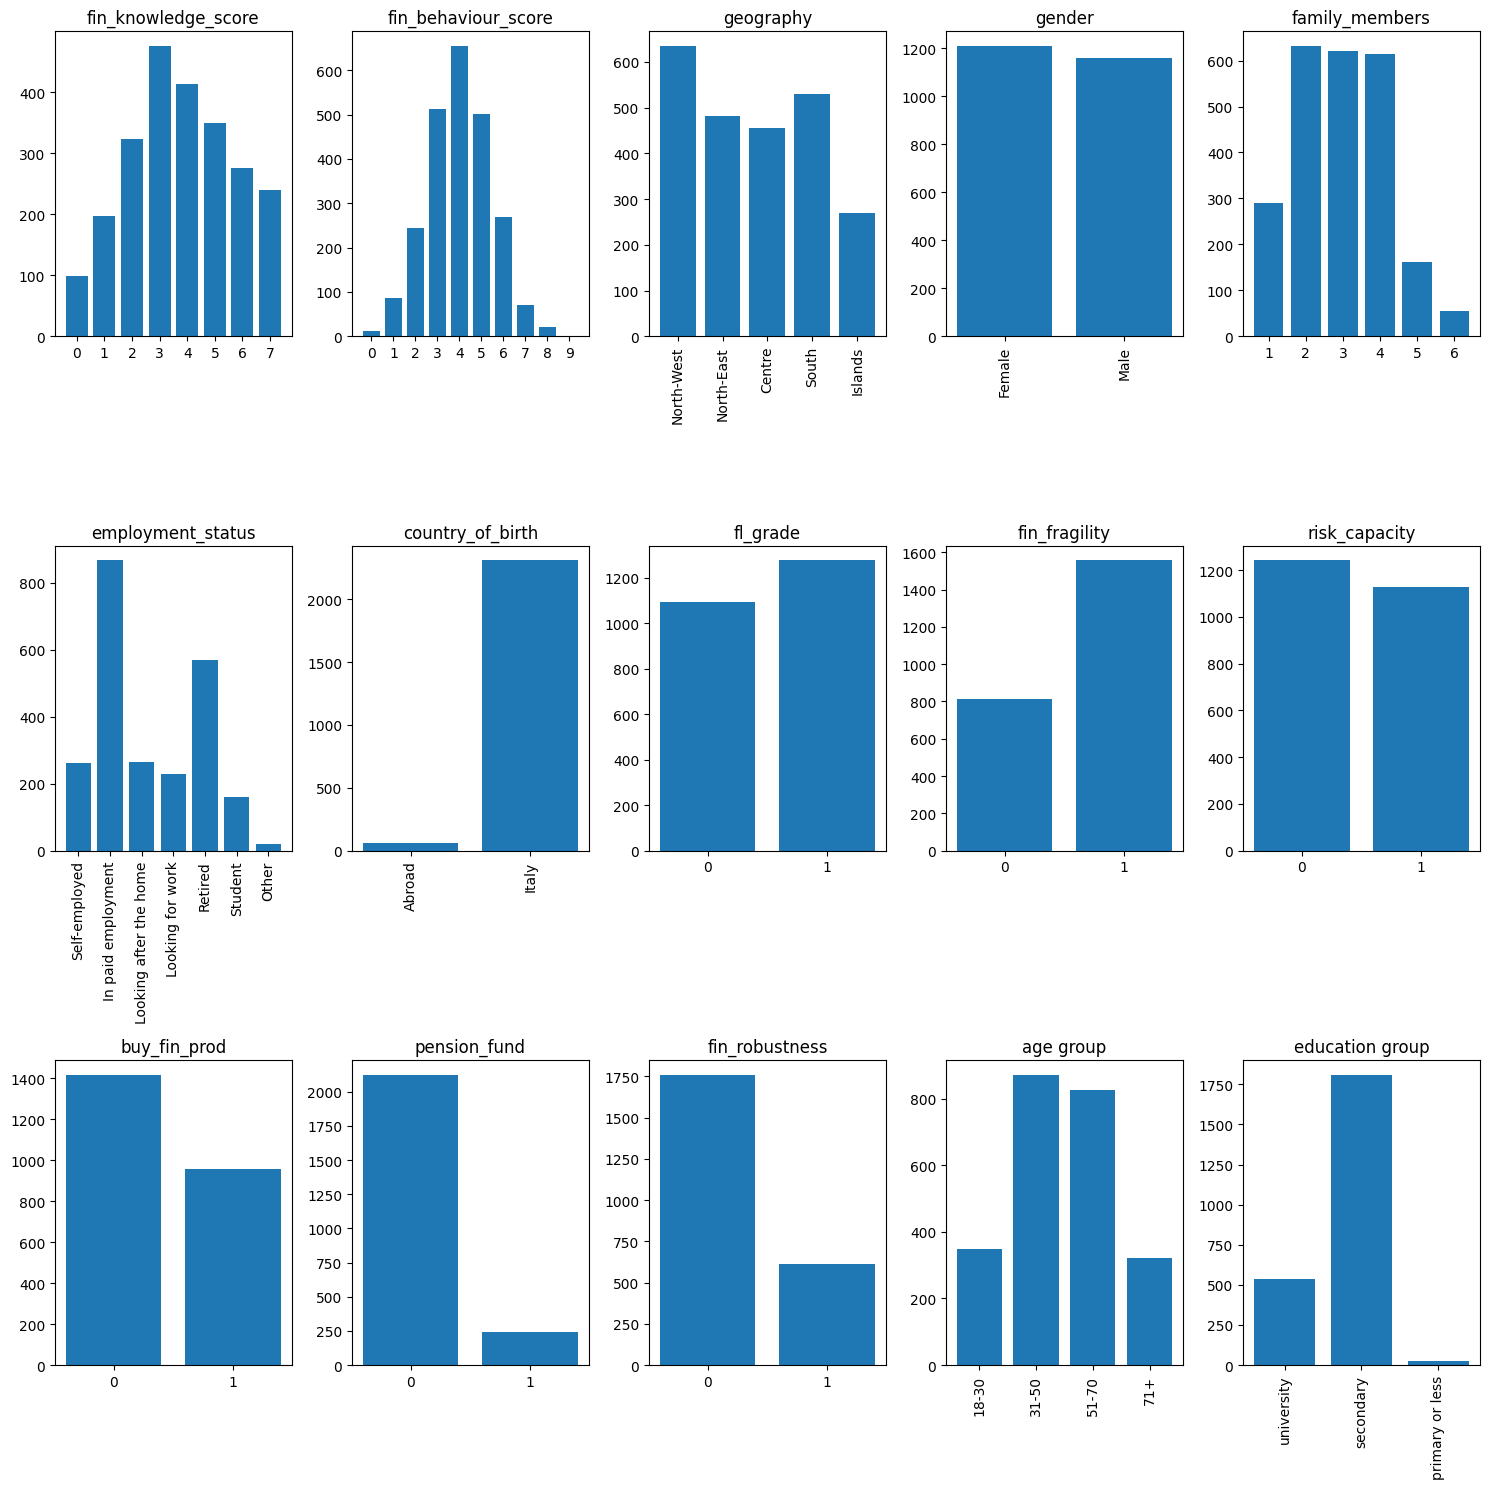

In [ ]:
excluded_columns = ["age", "education", "overall_fl_score", "fin_attitudes_score"]

included_columns = [col for col in new.columns if col not in excluded_columns]

num_rows = 3
num_cols = 5

fig = plt.figure(figsize=(15, 15))

for i, column in enumerate(included_columns):
    ax = fig.add_subplot(num_rows, num_cols, i + 1)
    value_counts = new[column].value_counts().sort_index()
    
    if column == 'gender':
        labels = ['Female', 'Male']
    elif column == 'geography':
        labels = ['North-West', 'North-East', 'Centre', 'South', 'Islands']
    elif column == 'country_of_birth':
        labels = ['Abroad', 'Italy']
    elif column == 'employment_status':
        labels = ['Self-employed', 'In paid employment', 'Looking after the home', 'Looking for work',
                  'Retired', 'Student', 'Other']
    else:
        labels = value_counts.index.astype(str)
    
    max_label_length = max(len(label) for label in labels)
    
    if max_label_length > 2:  
        ax.bar(labels, value_counts)
        ax.set_title(column)
        ax.set_xticklabels(labels, rotation=90)
    else:
        ax.bar(labels, value_counts)
        ax.set_title(column)

plt.tight_layout()
plt.show()

In [ ]:
len(new[new["fl_grade"]==0]) # 46% under average

1094

In [ ]:
len(new[new["employment_status"]==2]) + len(new[new["employment_status"]==6]) # in paid employment + retired = 60.4%

1436

In [ ]:
len(new[new["geography"]==5]) # islands 11.4%

270

In [ ]:
len(new[new["gender"]==0]) # women 50.9%

1210

In [ ]:
len(new[new["education group"]=="university"])

535

In [ ]:
print(len(new[new["fin_knowledge_score"]>=4]), # 53.7% score above sufficiency 
      len(new[new["fin_behaviour_score"]>=5])) # 36.2% score above sufficiency 

1277 861


In [ ]:
len(new[new["risk_capacity"]==0]) # 52.3%

1242

In [ ]:
len(new[new["fin_robustness"]==0]) # 74.1%

1760

In [ ]:
len(new[new["buy_fin_prod"]==0]) # 59.6%

1417

In [ ]:
len(new[new["pension_fund"]==1]) # 10.3%

245

Based on the provided correlation matrix, it can be observed that the variables displaying the strongest correlation are the financial behavior score in relation to the overall financial score (0.6), as well as the financial attitude score also in relation to the overall financial score (0.5). This implies that the two "sub-scores" which summarize the outcomes of specific questions in the assessment exhibit a moderate and positive correlation with the overall score. This identical correlation can also be observed between the financial grade and the overall score.

The only moderately substantial negative correlation was identified between the age and the family_members variable. This implies the likelihood of a decrease in the number of family members as age advances. The underlying reasons for this correlation remain uncertain; however, it may be plausible to make certain assumptions.

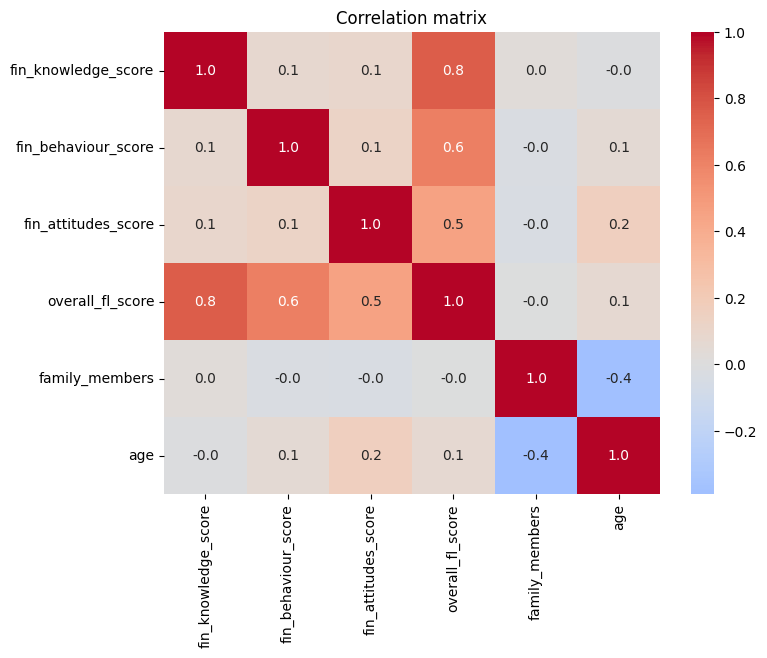

In [ ]:
correlation_matrix = new.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0, annot=True, fmt=".1f")
plt.title("Correlation matrix")
plt.show()

The present bar chart divides the variable "age" into four categories: 18-30, 31-50, 51-70, and 71 and over. Through this classification, it is possible to observe how the majority of respondents, constituting over 50% of the sample, fall within the two middle age groups, specifically between 31 and 70 years old. Additionally, from a visual standpoint, it can be noted that the majority of individuals have achieved a secondary level of education. Only a small percentage has completed primary or lower education, while the remaining portion has completed university studies.

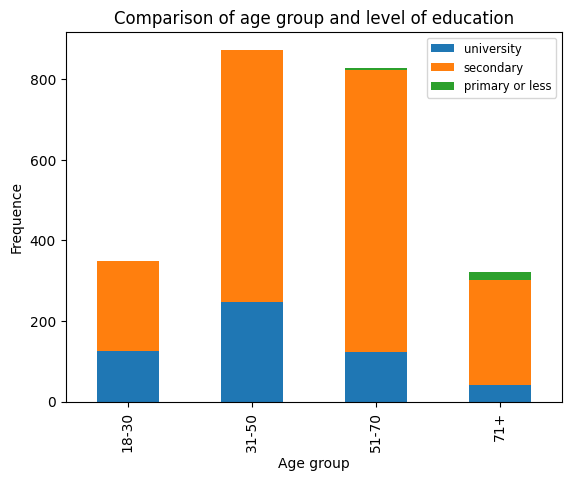

In [ ]:
frequencies = new.groupby(['age group', 'education group']).size().unstack()

ax = frequencies.plot(kind='bar', stacked=True)
plt.xlabel('Age group')
plt.ylabel('Frequence')
plt.title('Comparison of age group and level of education')
ax.legend(loc='upper right', fontsize = "small", bbox_to_anchor=(1.0, 1.0))
plt.show()

We will continue the analysis, taking into consideration the variable related to age, and focusing on the variable that evaluates financial skills (fl_grade). In this circumstance, an adequate balance is noticed between those who are above average and those who are below average. In fact, we have appropriately processed the data in order to create a binary score, representing only two values, which denote whether the individual has correctly answered at least half of the questions (surpassing the average) or has obtained an opposite result.

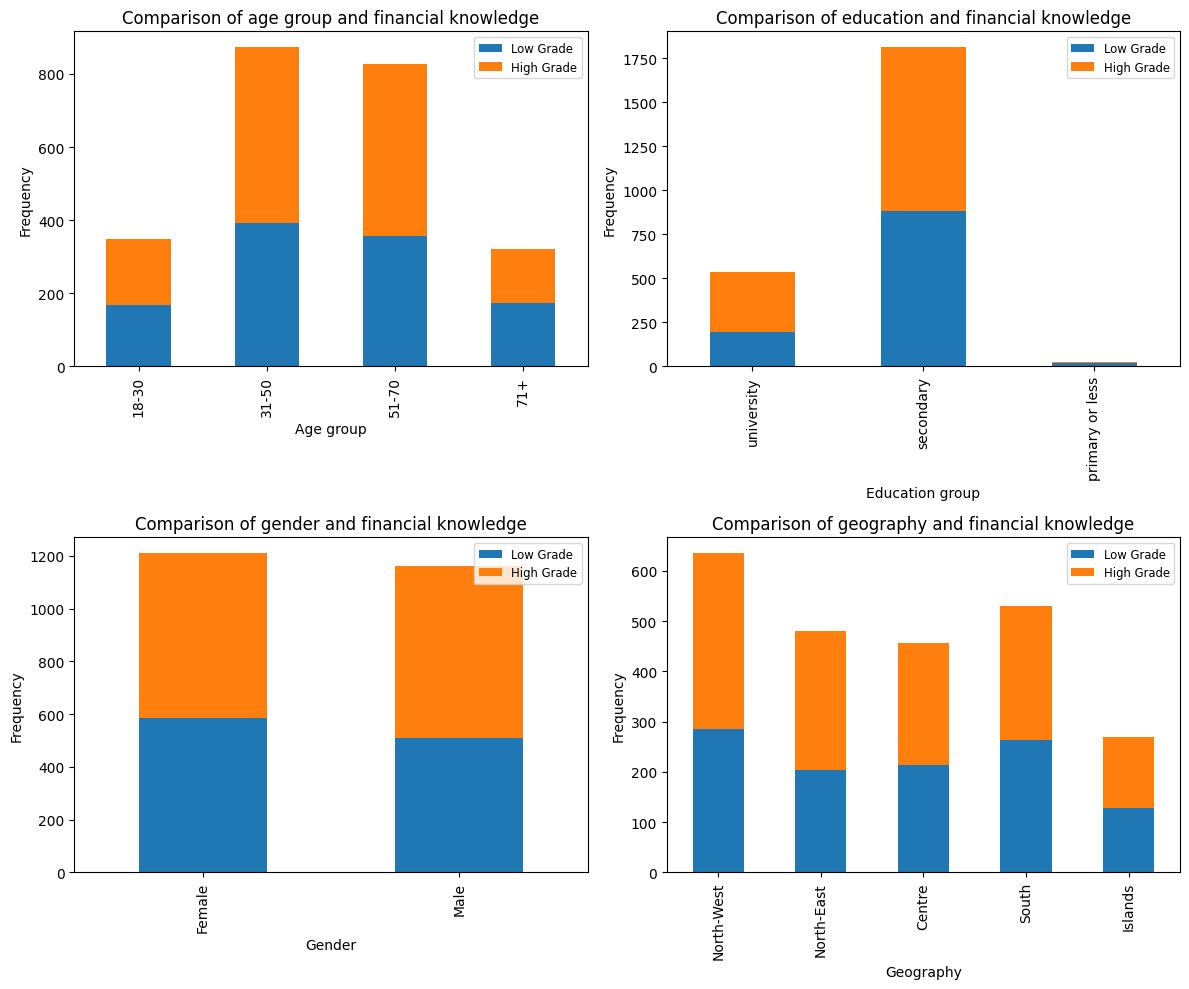

In [ ]:
plot_info = [
    {'groupby': ['age group', 'fl_grade'], 
     'x_label': 'Age group', 
     'title': 'Comparison of age group and financial knowledge'},
    {'groupby': ['education group', 'fl_grade'], 
     'x_label': 'Education group',
     'title': 'Comparison of education and financial knowledge'},
    {'groupby': ['gender', 'fl_grade'], 
     'x_label': 'Gender', 
     'title': 'Comparison of gender and financial knowledge'},
    {'groupby': ['geography', 'fl_grade'], 
     'x_label': 'Geography', 
     'title': 'Comparison of geography and financial knowledge'}
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, info in enumerate(plot_info):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    frequencies = new.groupby(info['groupby']).size().unstack()
    frequencies.rename(columns={0: 'Low Grade', 1: 'High Grade'}, inplace=True)
    
    if 'gender' in info['groupby']:
        frequencies.rename(index={0: 'Female', 1: 'Male'}, inplace=True)
    
    if 'geography' in info['groupby']:
        frequencies.rename(index={1: 'North-West', 2: 'North-East',
                                  3: 'Centre', 4: 'South', 5: 'Islands'}, inplace=True)
    
    ax = frequencies.plot(kind='bar', stacked=True, ax=ax)
    
    ax.set_xlabel(info['x_label'])
    ax.set_ylabel('Frequency')
    ax.set_title(info['title'])
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

In [ ]:
grouped = new.groupby(['gender', 'age group', 'education group'])[['fin_knowledge_score', 'fin_behaviour_score', 'fin_attitudes_score']].mean()
grouped

fin_knowledge_score  fin_behaviour_score  \
gender age group education group                                             
0      18-30     university                  3.824561             3.842105   
                 secondary                   3.372340             3.553191   
                 primary or less             2.000000             5.000000   
       31-50     university                  4.006667             4.240000   
                 secondary                   3.662500             4.043750   
                 primary or less                  NaN                  NaN   
       51-70     university                  4.250000             3.916667   
                 secondary                   3.793388             4.074380   
                 primary or less             3.000000             4.000000   
       71+       university                  3.350000             4.400000   
                 secondary                   3.208955             3.962687   
                 primary or less             2.600000             3.200000   
1      18-30     university                  4.130435             3.666667   
                 secondary                   3.656250             3.585938   
                 primary or less                  NaN                  NaN   
       31-50     university                  4.666667             4.250000   
                 secondary                   3.687296             4.052117   
                 primary or less                  NaN                  NaN   
       51-70     university                  4.904762             4.492063   
                 secondary                   3.887240             4.124629   
                 primary or less             1.500000             3.500000   
       71+       university                  4.750000             4.600000   
                 secondary                   3.546875             3.804688   
                 primary or less             2.555556             2.444444   

                                  fin_attitudes_score  
gender age group education group                       
0      18-30     university                  3.122737  
                 secondary                   2.799628  
                 primary or less             2.000000  
       31-50     university                  3.184460  
                 secondary                   3.079666  
                 primary or less                  NaN  
       51-70     university                  3.125017  
                 secondary                   3.286041  
                 primary or less             4.667000  
       71+       university                  3.308350  
                 secondary                   3.201470  
                 primary or less             3.233400  
1      18-30     university                  2.794681  
                 secondary                   2.643211  
                 primary or less                  NaN  
       31-50     university                  3.173583  
                 secondary                   3.029876  
                 primary or less                  NaN  
       51-70     university                  3.460302  
                 secondary                   3.172122  
                 primary or less             2.500000  
       71+       university                  3.650000  
                 secondary                   3.182297  
                 primary or less             3.222222

### One-hot encoding

In [ ]:
columns_new_2 = [col for col in new.columns if col not in ['fin_knowledge_score', 'overall_fl_score', 
                                                           'age', 'education']]
new_2 = new[columns_new_2]
new_2

,fin_behaviour_score,fin_attitudes_score,geography,gender,family_members,employment_status,country_of_birth,fl_grade,fin_fragility,risk_capacity,buy_fin_prod,pension_fund,fin_robustness,age group,education group
0,3,2.333,1,0,3,5,1,1,1,0,0,0,0,31-50,secondary
1,7,4.000,1,0,3,1,1,1,1,1,1,0,1,51-70,secondary
2,4,5.000,4,0,1,6,1,1,1,1,0,0,0,51-70,secondary
3,5,5.000,4,0,2,4,1,0,1,0,0,0,0,51-70,secondary
4,4,4.333,4,1,2,1,0,0,1,0,0,0,0,31-50,secondary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,1,3.333,3,1,4,9,1,0,1,0,0,0,0,18-30,secondary
2372,2,3.667,3,0,1,6,1,0,1,1,0,0,0,51-70,secondary
2373,1,3.333,3,0,2,2,1,0,1,1,1,0,0,31-50,university
2374,1,3.667,3,1,4,9,1,0,1,0,0,0,0,18-30,secondary


In [ ]:
numerical_discrete_cols = ['geography', 'family_members', 'employment_status']
categorical_cols = ['age group', 'education group']

df_encoded = pd.get_dummies(new_2, columns=numerical_discrete_cols, prefix=numerical_discrete_cols)

for col in categorical_cols:
    df_encoded = pd.concat([df_encoded, pd.get_dummies(new_2[col], prefix=col)], axis=1)

df_encoded.drop(columns=categorical_cols, inplace=True)

df_encoded.columns = ['New_Encoded_' + col for col in df_encoded.columns]

,New_Encoded_fin_behaviour_score,New_Encoded_fin_attitudes_score,New_Encoded_gender,New_Encoded_country_of_birth,New_Encoded_fl_grade,New_Encoded_fin_fragility,New_Encoded_risk_capacity,New_Encoded_buy_fin_prod,New_Encoded_pension_fund,New_Encoded_fin_robustness,...,New_Encoded_employment_status_6,New_Encoded_employment_status_9,New_Encoded_employment_status_10,New_Encoded_age group_18-30,New_Encoded_age group_31-50,New_Encoded_age group_51-70,New_Encoded_age group_71+,New_Encoded_education group_university,New_Encoded_education group_secondary,New_Encoded_education group_primary and less
0,3,2.333,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,7,4.000,0,1,1,1,1,1,0,1,...,0,0,0,0,0,1,0,0,1,0
2,4,5.000,0,1,1,1,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
3,5,5.000,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,4,4.333,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,1,3.333,1,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2372,2,3.667,0,1,0,1,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2373,1,3.333,0,1,0,1,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2374,1,3.667,1,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


## ML models

We are working on the variable "fl_grade" to transform it into a variable consisting of only two categories: pass - fail, in order for it to become binary.

In [ ]:
my_x = new.drop(columns=['age group', 'education group', "fin_knowledge_score", 'overall_fl_score', 'fl_grade'])
my_y = new['fl_grade']

(      fin_behaviour_score  fin_attitudes_score geography gender  \
 0                       3                2.333         1      0   
 1                       7                4.000         1      0   
 2                       4                5.000         4      0   
 3                       5                5.000         4      0   
 4                       4                4.333         4      1   
 ...                   ...                  ...       ...    ...   
 2371                    1                3.333         3      1   
 2372                    2                3.667         3      0   
 2373                    1                3.333         3      0   
 2374                    1                3.667         3      1   
 2375                    5                4.000         3      0   
 
       family_members employment_status country_of_birth  fin_fragility  \
 0                  3                 5                1              1   
 1                  3           

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(my_x, my_y, test_size=0.2, random_state=0)

In [ ]:
numeric_features = my_x.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = my_x.select_dtypes(include=['object']).columns.tolist()

scaler = StandardScaler()
x_train[numeric_features] = scaler.fit_transform(x_train[numeric_features])
x_test[numeric_features] = scaler.transform(x_test[numeric_features])

NameError: name 'X_train' is not defined

In [ ]:
numeric_features

['fin_behaviour_score', 'fin_attitudes_score', 'family_members', 'age']

### Logit Regression

In [ ]:
logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.654728
         Iterations 5
                          Results: Logit
Model:                Logit            Method:           MLE       
Dependent Variable:   fl_grade         Pseudo R-squared: 0.051     
Date:                 2023-09-06 09:26 AIC:              2510.7274 
No. Observations:     1896             BIC:              2588.3924 
Df Model:             13               Log-Likelihood:   -1241.4   
Df Residuals:         1882             LL-Null:          -1308.3   
Converged:            1.0000           LLR p-value:      3.6435e-22
No. Iterations:       5.0000           Scale:            1.0000    
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
fin_behaviour_score  0.0453   0.0526  0.8612 0.3891 -0.0578  0.1484
fin_attitudes_score  0.0635   0.0492  1.2

In [ ]:
logreg_model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=0)

logreg_model.fit(x_train, y_train)

cv_scores = cross_val_score(logreg_model, x_train, y_train, cv=10, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores)) # accuracy on training set = 0.598

Cross-validation scores: [0.61052632 0.6        0.55263158 0.63157895 0.62631579 0.57894737
 0.5978836  0.64021164 0.57142857 0.56613757]
Mean CV accuracy: 0.5975661375661375


In [ ]:
y_pred = logreg_model.predict(x_test)

print(classification_report(y_test, y_pred)) # accuracy on test set = 0.61

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       221
           1       0.63      0.67      0.65       254

    accuracy                           0.61       475
   macro avg       0.61      0.61      0.61       475
weighted avg       0.61      0.61      0.61       475



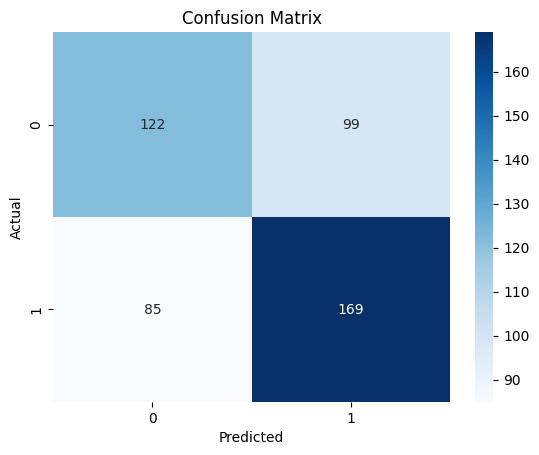

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

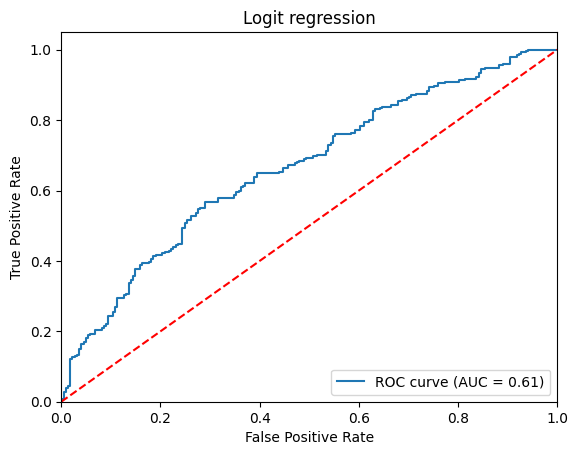

In [ ]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg_model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Logit regression")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Decision Tree

In [ ]:
clf = DecisionTreeClassifier(
    ccp_alpha=0.002,
    random_state=0
)

clf.fit(x_train, y_train)

cv_scores = cross_val_score(clf, x_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores)) # accuracy on training = 0.59

Cross-Validation Scores: [0.61052632 0.62631579 0.57894737 0.61052632 0.55263158 0.61578947
 0.50793651 0.60846561 0.59259259 0.6031746 ]
Mean CV Score: 0.5906906154274576


In [ ]:
y_pred = clf.predict(x_test)
report = classification_report(y_test, y_pred)
print("Classification Report on Test Set:\n", report) # accuracy on test = 0.6

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.60      0.40      0.48       221
           1       0.59      0.77      0.67       254

    accuracy                           0.60       475
   macro avg       0.60      0.58      0.57       475
weighted avg       0.60      0.60      0.58       475



In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=my_x.columns,  
                                class_names=my_y.unique().astype(str),
                                filled=True, rounded=True, special_characters=True)

graph = graphviz.Source(dot_data)  
graph.render("decision_tree")

'decision_tree.pdf'

In [ ]:
feature_importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": my_x.columns, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
                Feature  Importance
10        risk_capacity    0.505751
7             education    0.385695
13       fin_robustness    0.108554
0   fin_behaviour_score    0.000000
1   fin_attitudes_score    0.000000
2             geography    0.000000
3                gender    0.000000
4        family_members    0.000000
5     employment_status    0.000000
6                   age    0.000000
8      country_of_birth    0.000000
9         fin_fragility    0.000000
11         buy_fin_prod    0.000000
12         pension_fund    0.000000


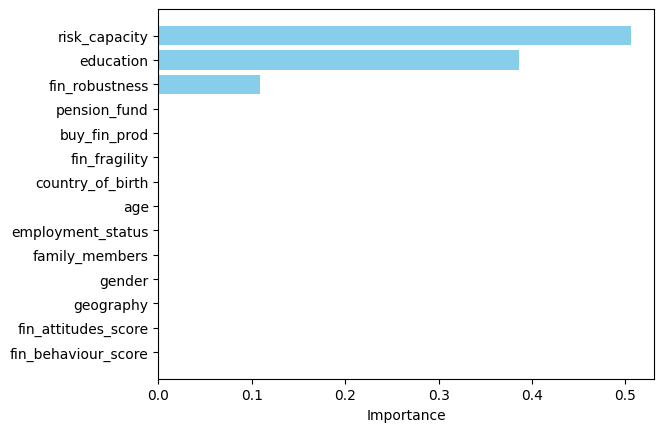

In [ ]:
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=True)
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')

plt.xlabel('Importance')

plt.show()

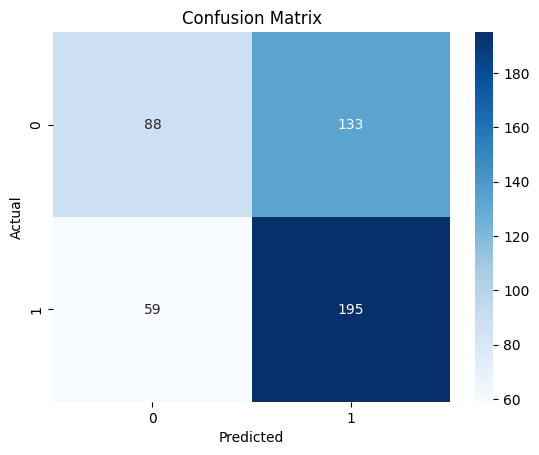

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

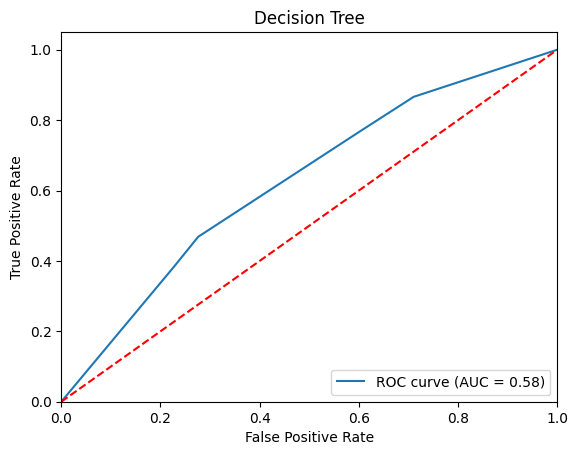

In [ ]:
dt_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Decision Tree")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

### Random Forest

In [ ]:
clf = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=11,
    max_features=2,
    random_state=0
)

clf.fit(x_train, y_train)

cv_scores = cross_val_score(clf, x_train, y_train, cv=10)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores)) # accuracy on training = 0.598

Cross-Validation Scores: [0.62105263 0.62631579 0.57894737 0.6        0.58947368 0.61052632
 0.58730159 0.60846561 0.58730159 0.56613757]
Mean CV Score: 0.5975522138680034


In [ ]:
y_pred = clf.predict(x_test)

report = classification_report(y_test, y_pred)
print("Classification Report on Test Set:\n", report) # accuracy on test = 0.61

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.60      0.53      0.56       221
           1       0.63      0.69      0.66       254

    accuracy                           0.61       475
   macro avg       0.61      0.61      0.61       475
weighted avg       0.61      0.61      0.61       475



In [ ]:
feature_importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": my_x.columns, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
                Feature  Importance
6                   age    0.154672
1   fin_attitudes_score    0.124682
7             education    0.120687
10        risk_capacity    0.097708
13       fin_robustness    0.090543
0   fin_behaviour_score    0.072439
2             geography    0.070737
5     employment_status    0.064443
4        family_members    0.062544
9         fin_fragility    0.054238
3                gender    0.031885
11         buy_fin_prod    0.028777
12         pension_fund    0.024851
8      country_of_birth    0.001793


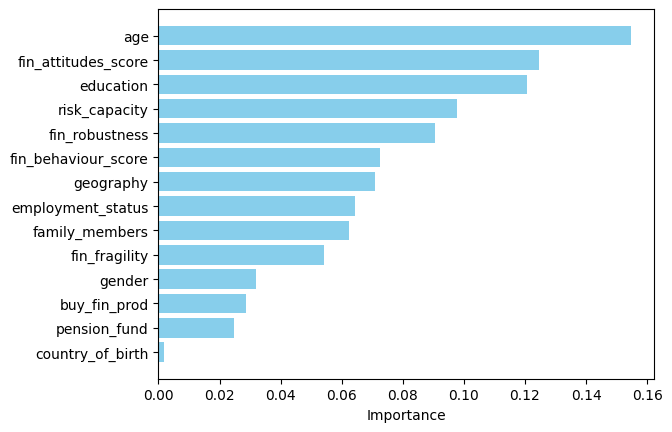

In [ ]:
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=True)
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')

plt.xlabel('Importance')

plt.show()

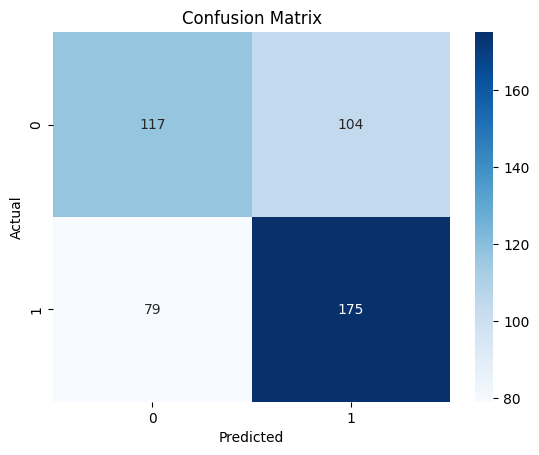

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

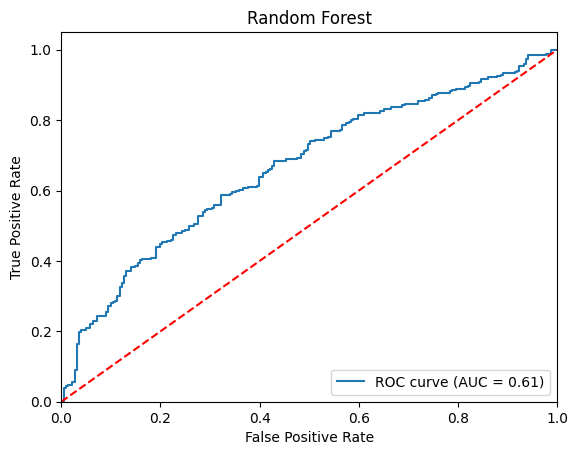

In [ ]:
rf_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Random Forest")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

### Gradient Boosting

In [ ]:
model_gbm = GradientBoostingClassifier(n_estimators=500,
                                        learning_rate=0.1, 
                                        max_depth=3, 
                                        random_state=0)
model_gbm.fit(x_train, y_train)

#cv = KFold(n_splits=10, shuffle=True, random_state=0)
cv_scores = cross_val_score(model_gbm, x_train, y_train, cv=10, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores)) # accuracy on training set = 0.571

Cross-validation scores: [0.51578947 0.58947368 0.51052632 0.54210526 0.57894737 0.61578947
 0.58201058 0.58201058 0.6031746  0.59259259]
Mean CV accuracy: 0.5712419938735728


In [ ]:
#y_pred_cv = cross_val_predict(model_gbm, my_x, my_y, cv=cv)
y_pred = model_gbm.predict(x_test)

print(classification_report(y_test, y_pred)) # accuracy on test set = 0.58

              precision    recall  f1-score   support

           0       0.55      0.48      0.51       221
           1       0.60      0.67      0.63       254

    accuracy                           0.58       475
   macro avg       0.58      0.57      0.57       475
weighted avg       0.58      0.58      0.58       475



In [ ]:
feature_importance = model_gbm.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": my_x.columns, "Importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print("Feature Importance:")
print(feature_importance_df)

Feature Importance:
                Feature  Importance
6                   age    0.247120
1   fin_attitudes_score    0.123770
2             geography    0.099246
0   fin_behaviour_score    0.098071
7             education    0.092927
4        family_members    0.066458
10        risk_capacity    0.066036
13       fin_robustness    0.059320
5     employment_status    0.041862
3                gender    0.030369
11         buy_fin_prod    0.027565
9         fin_fragility    0.023217
12         pension_fund    0.020021
8      country_of_birth    0.004018


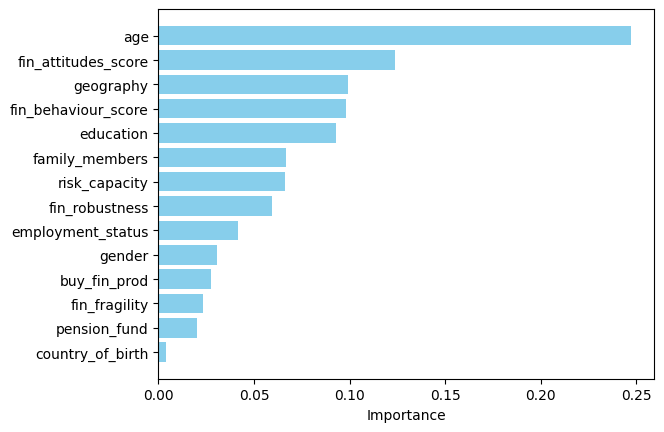

In [ ]:
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=True)
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')

plt.xlabel('Importance')

plt.show()

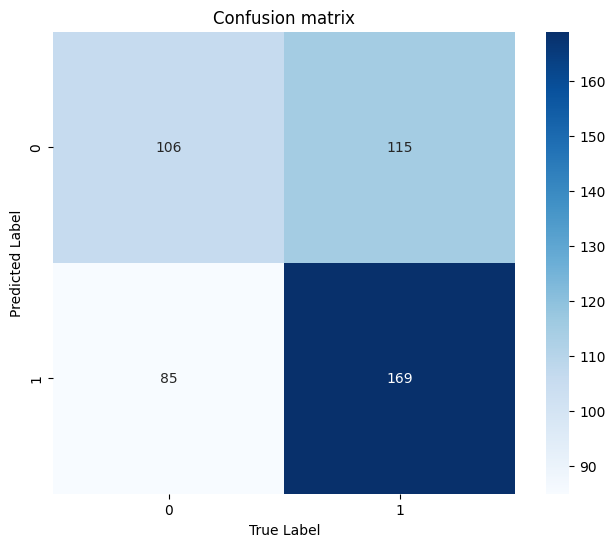

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion matrix')

plt.show()

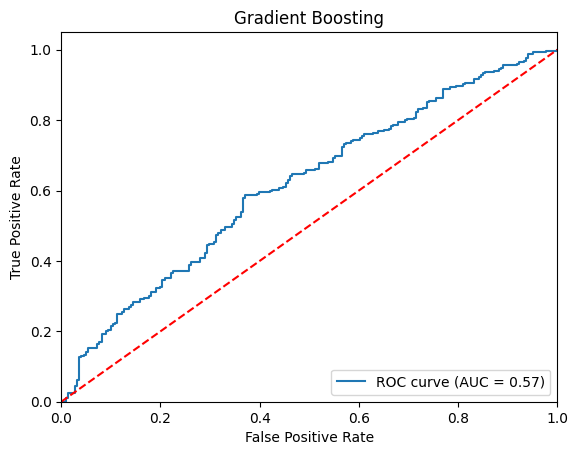

In [ ]:
gbm_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model_gbm.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % gbm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("Gradient Boosting")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('gbm_ROC')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=13a2aef1-ede0-485b-846d-6e8736a62648' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>